In [1]:
import rasterio as rio
from sklearn import cluster
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## Kmeans clustering:
user inputs: training raster, raster to predict, number of clusters, raster bands to use (as list of bands or "all")

In [2]:
def kmeans_cluster(train_rast_path, predict_rast_path, num_clusters, bands="all"):
    if bands=="all":
        with rio.open(train_rast_path, "r") as src:
            ## create an empty array with same dimension and data type
            imgxyb = np.empty((src.height, src.width, src.count), src.meta['dtype'])
            ## loop through the raster's bands to fill the empty array
            for band in range(imgxyb.shape[2]):
                imgxyb[:,:,band] = src.read(band+1)
                #imgxyb[np.isnan(imgxyb)] = 0
            ## convert to 1d array
            img1d=imgxyb[:,:,:src.count].reshape((imgxyb.shape[0]*imgxyb.shape[1],imgxyb.shape[2]))
            #img1d[np.isnan(img1d)] = 0
            img1d[img1d<-10000] = 0 # made everything zero     
            ## create an object of the classifier and assign number of clusters
            cl=cluster.KMeans(n_clusters=int(num_clusters)) 
            param=cl.fit(img1d) # train it
            img_cl=cl.labels_ # get the labels of the classes
            img_cl=img_cl.reshape(imgxyb[:,:,0].shape) # reshape labels to a 3d array (one band only)
            input_pred_path=train_rast_path[:-4] + "_train_img_all_" + str(imgxyb.shape[2]) + "b" + str(num_clusters) + "cl.tif"
            
            ## PLOT
            kmeans = KMeans(n_clusters=num_clusters)
            kmeans.fit(img1d)
            y_kmeans = kmeans.predict(img1d)
            print(y_kmeans)
            plt.scatter(img1d[:, 0], img1d[:, 1], c=y_kmeans, s=5, cmap='Spectral')
            centers = kmeans.cluster_centers_
            plt.scatter(centers[:, 0], centers[:, 1], c='gray', s=20, alpha=0.5);

            # export training image
            with rio.open(input_pred_path, 'w', driver='GTiff', height=img_cl.shape[0], width=img_cl.shape[1], count=1, dtype=img_cl.dtype, crs=src.crs, transform=src.transform) as dst:
                print('Exporting training clusters... ' + input_pred_path)
                dst.write(img_cl, 1)
                
            if train_rast_path != predict_rast_path:
                # open the raster image to predict 
                with rio.open(predict_rast_path, "r") as pred:
                    pred_xyb=np.empty((pred.height, pred.width, pred.count), pred.meta['dtype'])
                    for band in range(pred_xyb.shape[2]):
                        pred_xyb[:,:,band] = pred.read(band+1)
                    pred_1d=pred_xyb[:,:,:pred.count].reshape(pred_xyb.shape[0]*pred_xyb.shape[1], pred_xyb.shape[2])
                    pred_clust=cl.predict(pred_1d)
                    pred_cul=pred_clust
                    pred_cul=pred_cul.reshape(pred_xyb[:,:,0].shape)

                    # export prediction
                    pred_path=predict_rast_path[:-4] + "_pred_img_all" + str(num_clusters) + "cl.tif"
                    with rio.open(pred_path, 'w', driver='GTiff', height=pred_cul.shape[0], width=pred_cul.shape[1], count=1, dtype=pred_cul.dtype, crs=pred.crs, transform=pred.transform) as dst:
                        print('Exporting predicted raster... ' + pred_path)
                        dst.write(pred_cul, 1)
            else:
                 return(print('No new raster to predict'))
    else:
        with rio.open(train_rast_path, "r") as src:
            # create an empty array with same dimension and data type
            imgxyb=np.empty((src.height, src.width, len(bands)), src.meta['dtype']) #src.count > len(bands)
            # loop through the raster's bands to fill the empty array
            for i, band in enumerate(bands):
                imgxyb[:,:,i] = src.read(band)
                #imgxyb[np.isnan(imgxyb)] = 0
                
            # convert to 1d array
            img1d=imgxyb[:,:,:len(bands)].reshape((imgxyb.shape[0]*imgxyb.shape[1],imgxyb.shape[2])) #src.count > len(bands)
            #img1d[np.isnan(img1d)] = 0
            img1d[img1d<-10000] = 0
            print(img1d)
            # assign number of clusters
            cl=cluster.KMeans(n_clusters=num_clusters) # create an object of the classifier
            param=cl.fit(img1d) # train it
            img_cl=cl.labels_ # get the labels of the classes
            img_cl=img_cl.reshape(imgxyb[:,:,0].shape) # reshape labels to a 3d array (one band only)
            input_pred_path = train_rast_path[:-4] + "_train_img_" + str(len(bands)) + "b_" + str(num_clusters) + "cl.tif" 
            
            ## PLOT
            kmeans = KMeans(n_clusters=num_clusters)
            kmeans.fit(img1d)
            y_kmeans = kmeans.predict(img1d)
            plt.scatter(img1d[:, 0], img1d[:, 1], c=y_kmeans, s=5, cmap='Spectral')
            centers = kmeans.cluster_centers_
            plt.scatter(centers[:, 0], centers[:, 1], c='gray', s=20, alpha=0.5);
            plt.savefig('cluster.png')

            # export training image
            with rio.open(input_pred_path, 'w', driver='GTiff', height=img_cl.shape[0], width=img_cl.shape[1], count=1, dtype=img_cl.dtype, crs=src.crs, transform=src.transform) as dst:
                print('Exporting training clusters to ' + input_pred_path)
                dst.write(img_cl, 1)
                input_sub_path = train_rast_path[:-4] + "subset" + str(len(bands)) + "b.tif"
            if train_rast_path != predict_rast_path:
                # open the raster image to predict 
                with rio.open(predict_rast_path, "r") as pred:
                    pred_xyb=np.empty((pred.height, pred.width, len(bands)), pred.meta['dtype']) #pred.count > len(bands)
                    for band in range(pred_xyb.shape[2]):
                        pred_xyb[:,:,band]=pred.read(band+1)
                    pred_1d=pred_xyb[:,:,:len(bands)].reshape(pred_xyb.shape[0]*pred_xyb.shape[1], pred_xyb.shape[2]) #pred.count > len(bands)
                    pred_clust=cl.predict(pred_1d)
                    pred_cul=pred_clust
                    pred_cul=pred_cul.reshape(pred_xyb[:,:,0].shape)

                    # export prediction
                    pred_path=predict_rast_path[:-4] + "_pred_img_" + str(len(bands)) + "b_" + str(num_clusters) + "cl.tif"
                    with rio.open(pred_path, 'w', driver='GTiff', height=pred_cul.shape[0], width=pred_cul.shape[1], count=1, dtype=pred_cul.dtype, crs=pred.crs, transform=pred.transform) as dst:
                        print('Exporting predicted raster... ' + pred_path)
                        dst.write(pred_cul, 1)
            else:
                return(print('No new raster to predict'))

[12 12 12 ...  1  1  1]
Exporting training clusters... /home/lsharwood/rsync/kmeans_cluster/NI147/NI147_EVI2_GCVI_KNDVI_NBR_MMA_mon_smallsub_sub_6b_train_img_all_6b15cl.tif
No new raster to predict


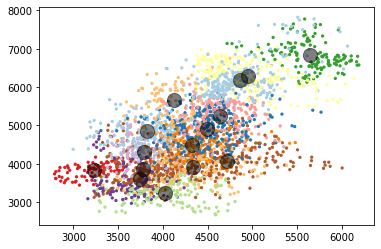

In [53]:
train="/home/lsharwood/rsync/kmeans_cluster/NI147/NI147_EVI2_GCVI_KNDVI_NBR_MMA_mon_smallsub_sub_6b.tif"
predict=train

append_name= "147SMALL"
NI_385_bands = [1,2,3,5,6,7,8,13,14,16,18,21,22,23,24,29,31,33,43,44,49,50,51,58,59]
NI_295_bands = [2,4,5,7,8,9,19,20,22,23,26,28,34,35,44,49,50,52,53,54,57]
NI_258_bands = [1,2,4,5,6,7,13,14,16,18,19,25,26,31,34,37,38,46,48,49,50,53,58,59]
NI147SMALL=[5,14,15,20,21,34,35,36]
kmeans_cluster(train, predict, 15, "all")

[[3304 4586 6237 ... 6972 5094 4060]
 [3188 4482 6174 ... 6991 5231 4165]
 [3170 4477 6222 ... 7022 5447 4345]
 ...
 [4702 4934 6152 ... 6446 5358 4306]
 [4740 4920 6044 ... 6404 5354 4254]
 [4731 5066 6016 ... 6373 5449 4357]]
Exporting training clusters to /home/lsharwood/rsync/kmeans_cluster/NI147/NI147_EVI2_GCVI_KNDVI_NBR_MMA_mon_train_img_17b_8cl.tif
No new raster to predict


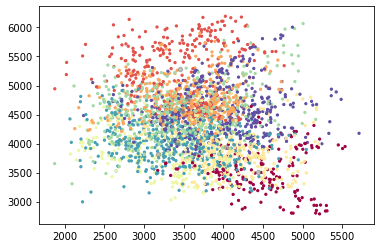

In [77]:
train="/home/lsharwood/rsync/kmeans_cluster/NI147/NI147_EVI2_GCVI_KNDVI_NBR_MMA_mon.tif"
predict=train
NI_147=[3,5,14,15,18,19,20,21,30,31,33,34,35,36,44,49,50]
NI147SMALL=[5,14,15,20,21,34,35,36]
kmeans_cluster(train, predict, 8, NI_147)


[[4586 6237 6384 ... 5919 5076 3851]
 [4482 6174 6246 ... 5973 5100 3774]
 [4477 6222 6227 ... 6092 5228 4006]
 ...
 [4934 6152 6094 ... 6234 4951 2998]
 [4920 6044 5868 ... 6135 4860 2877]
 [5066 6016 5650 ... 6131 4917 2946]]
Exporting training clusters to /home/lsharwood/rsync/kmeans_cluster/NI147/NI147_EVI2_GCVI_KNDVI_NBR_MMA_mon_train_img_8b_7cl.tif
No new raster to predict


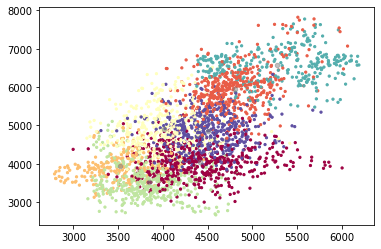

In [80]:
kmeans_cluster(train, predict, 7, NI147SMALL)


[[4567 4052 4900 ... 5996 3215 5834]
 [4838 3887 5037 ... 6024 3031 5852]
 [4915 4459 5241 ... 6048 2666 5876]
 ...
 [2029 3156 3844 ... 3571 3416 2587]
 [2057 2995 3724 ... 2824 3683 1687]
 [2305 2909 3789 ... 1741 3744 1270]]
Exporting training clusters to /home/lsharwood/rsync/kmeans_cluster/NI285/NI258_2018_EVI2_GCVI_KNDVI_NBR_MMM_mon_train_img_12b_6cl.tif
No new raster to predict


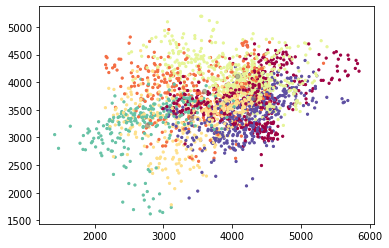

In [5]:
train="/home/lsharwood/rsync/kmeans_cluster/NI285/NI258_2018_EVI2_GCVI_KNDVI_NBR_MMM_mon.tif"
predict=train
NI_258_bands = [1,2,4,5,6,7,13,14,16,18,19,25,26,31,34,37,38,46,48,49,50,53,58,59]
NI_258 =  [3,9,10,12,13,16,18,19,25,26,27,31,42,43,48,49,51,53,60]
NI258=[3,8,9,12,18,25,26,27,42,43,53,59]
kmeans_cluster(train, predict, 6, NI258)

[[2943 2415 3058 ... 5981 5916 5602]
 [2985 2441 3965 ... 5946 6037 5630]
 [2942 2416 3664 ... 5710 6070 5626]
 ...
 [3079 2689 3621 ... 5600 5537 5839]
 [3023 2610 3708 ... 5676 5635 5904]
 [3004 2611 4018 ... 5436 5806 6030]]
Exporting training clusters to /home/lsharwood/rsync/kmeans_cluster/NI307/NI307_EVI2_GCVI_KNDVI_NBR_MMA_Mon_train_img_21b_8cl.tif
No new raster to predict


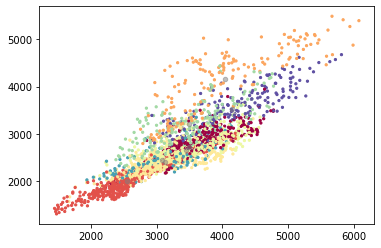

In [11]:
train="/home/lsharwood/rsync/kmeans_cluster/NI307/NI307_EVI2_GCVI_KNDVI_NBR_MMA_Mon.tif"
predict=train
NI_307_bands = [3,4,5,8,10,11,12,13,18,19,20,26,27,28,29,33,34,35,36,38,42,43,48,54,55]
NI_307_band = [4,5,8,10,11,12,13,19,20,26,27,28,29,34,35,36,38,42,43,54,55]
NI_307_smol = [3,8,11,12,19,27,29,33,35,38,42]
kmeans_cluster(train, predict, 8, NI_307_band)

[[6284 6235 7400 ... 6513 3620 3597]
 [6527 6160 8165 ... 6617 3113 4092]
 [6648 6013 8288 ... 6642 3132 4245]
 ...
 [3481 4134 6033 ... 6248 5255  597]
 [3761 4526 7002 ... 6497 5521  670]
 [3899 4954 7646 ... 6578 5498  688]]
Exporting training clusters to /home/lsharwood/rsync/kmeans_cluster/NI407/NI407_EVI2_GCVI_KNDVI_NBR_MMA_Mon_train_img_7b_4cl.tif
No new raster to predict


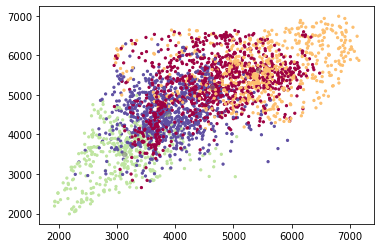

In [7]:
train="/home/lsharwood/rsync/kmeans_cluster/NI407/NI407_EVI2_GCVI_KNDVI_NBR_MMA_Mon.tif"
predict=train
NI_407_bands = [1,2,3,4,5,8,9,10,25,29,30,41,44,45,46,47,48,49]
NI407=[9,13,29,30,44,48,52]
kmeans_cluster(train, predict, 4, NI407)

[[5309 1653 3656 ... 1135 4225 3637]
 [5459 1683 3776 ... 1033 4237 3795]
 [5450 1631 3819 ... 1007 4195 3713]
 ...
 [4756 1271 3485 ...  947 4300 5323]
 [4601 1269 3332 ...  835 4395 5324]
 [4471 1317 3154 ...  841 4291 5295]]
Exporting training clusters to /home/lsharwood/rsync/kmeans_cluster/NI295_NI385/NI385_NI295_EVI2_GCVI_KNDVI_NBR_MMA_Mon_train_img_25b_15cl.tif
No new raster to predict


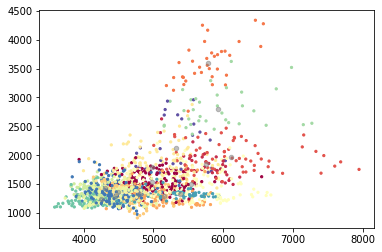

In [18]:
train="/home/lsharwood/rsync/kmeans_cluster/NI295_NI385/NI385_NI295_EVI2_GCVI_KNDVI_NBR_MMA_Mon.tif"
predict=train
NI_385_bands = [1,2,3,5,6,7,8,13,14,16,18,21,22,23,24,29,31,33,43,44,49,50,51,58,59]
NI_295_385 = [1,2,3,4,5,6,7,8,9,13,14,16,18,19,20,21,22,23,24,26,28,29,31,33,34,35,43,44,49,50,51,52,53,54,57,58,59]

kmeans_cluster(train, predict, 15, NI_385_bands)

[[3153 4274 3432 ... 3027 4131 4424]
 [3189 4520 3457 ... 2927 4279 4432]
 [3206 4463 3561 ... 2731 4265 4475]
 ...
 [4072 3889 3690 ... 1173 4323 4492]
 [3714 3924 3720 ... 1537 4547 4434]
 [3262 4052 3750 ... 1831 4792 4366]]
Exporting training clusters to /home/lsharwood/rsync/kmeans_cluster/NI295_NI385/NI385_NI295_EVI2_GCVI_KNDVI_NBR_MMA_Mon_train_img_8b_6cl.tif
No new raster to predict


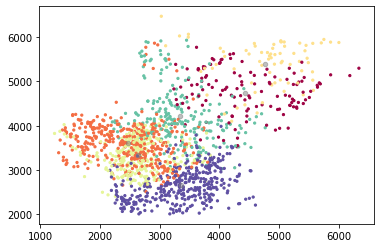

In [24]:
train="/home/lsharwood/rsync/kmeans_cluster/NI295_NI385/NI385_NI295_EVI2_GCVI_KNDVI_NBR_MMA_Mon.tif"
predict=train
NI_385_bands = [1,2,3,5,6,7,8,13,14,16,18,21,22,23,24,29,31,33,43,44,49,50,51,58,59]
NI_295_385 = [1,2,3,4,5,6,7,8,9,13,14,16,18,19,20,21,22,23,24,26,28,29,31,33,34,35,43,44,49,50,51,52,53,54,57,58,59]
NI_295=[4,9,26,28,52,53,54,57]
kmeans_cluster(train, predict,6, NI_295)

In [ ]:
NI_295_bands = [2,4,5,7,8,9,19,20,22,23,26,34,35,49,50,52,53,54,57]

In [ ]:
S2_bands=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 89, 90]
S1_bands=[76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90] 

append_name = "plots_S1_S2_NDJFMAM"
sub_bands=[1, 2, 3, 4, 5, 6, 7, 8, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 59, 60, 76, 77, 78, 79, 80, 81, 82, 83, 88, 89, 90]
sub_bands1=[1, 2, 3, 4, 5, 6, 7, 8, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 59, 60]
append_name1 = "plots_S2_NDJFMAM"

EVI2_bands=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] 
EVI2_NDJFMAM=[1, 2, 3, 4, 5, 6, 7, 8, 14, 15] 

kmeans_cluster(train, predict, 15, "EVI2_NDJFMAM", EVI2_NDJFMAM)


GCVI_bands=[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30] 
GCVI_bands_NDJFMAM=[16, 17, 18, 19, 20, 21, 22, 23, 29, 30] 

kmeans_cluster(train, predict, 6, "GCVI_NDJFMAM", GCVI_bands_NDJFMAM)



GCVI_bands=[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30] 
GCVI_bands_NDJFMAM=[16, 17, 18, 19, 20, 21, 22, 23, 29, 30] 

kmeans_cluster(train, predict, 6, "GCVI_NDJFMAM", GCVI_bands_NDJFMAM)


KNDVI_bands=[31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
KNDVI_bands_NDJFMAM=[31, 32, 33, 34, 35, 36, 37, 38, 44, 45]

kmeans_cluster(train, predict, 6, "KNDVI_bands_NDJFMAM", KNDVI_bands_NDJFMAM)


NBR_bands=[46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
NBR_bands_NDJFMAM=[46, 47, 48, 49, 50, 51, 52, 53, 59, 60]
kmeans_cluster(train, predict, 6, "NBR_NDJFMAM", NBR_bands_NDJFMAM)

In [26]:
from sklearn.metrics import pairwise_distances_argmin


[[5309 1653 3656 ... 4424 4225 3637]
 [5459 1683 3776 ... 4432 4237 3795]
 [5450 1631 3819 ... 4475 4195 3713]
 ...
 [4756 1271 3485 ... 4492 4300 5323]
 [4601 1269 3332 ... 4434 4395 5324]
 [4471 1317 3154 ... 4366 4291 5295]]
[1 1 1 ... 1 1 1]
Exporting training clusters to /home/lsharwood/rsync/kmeans_cluster/NI295_NI385/NI385_NI295_EVI2_GCVI_KNDVI_NBR_MMA_Mon_train_img_37b_4cl.tif
No new raster to predict


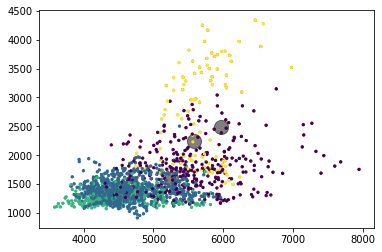

In [31]:
train_rast_path = "/home/lsharwood/rsync/kmeans_cluster/NI295_NI385/NI385_NI295_EVI2_GCVI_KNDVI_NBR_MMA_Mon.tif"
predict_rast_path=train_rast_path
bands = [1,2,3,4,5,6,7,8,9,13,14,16,18,19,20,21,22,23,24,26,28,29,31,33,34,35,43,44,49,50,51,52,53,54,57,58,59]
num_clusters = 4


with rio.open(train_rast_path, "r") as src:
            # create an empty array with same dimension and data type
            imgxyb=np.empty((src.height, src.width, len(bands)), src.meta['dtype']) #src.count > len(bands)
            # loop through the raster's bands to fill the empty array
            for i, band in enumerate(bands):
                imgxyb[:,:,i] = src.read(band)
                #imgxyb[np.isnan(imgxyb)] = 0
                
            # convert to 1d array
            img1d=imgxyb[:,:,:len(bands)].reshape((imgxyb.shape[0]*imgxyb.shape[1],imgxyb.shape[2])) #src.count > len(bands)
            #img1d[np.isnan(img1d)] = 0
            img1d[img1d<-10000] = 0
            print(img1d)
            # assign number of clusters
            cl=cluster.KMeans(n_clusters=num_clusters) # create an object of the classifier
            param=cl.fit(img1d) # train it
            img_cl=cl.labels_ # get the labels of the classes
            img_cl=img_cl.reshape(imgxyb[:,:,0].shape) # reshape labels to a 3d array (one band only)
            ## PLOT
            kmeans = KMeans(n_clusters=num_clusters)
            kmeans.fit(img1d)
            y_kmeans = kmeans.predict(img1d)
            print(y_kmeans)
            plt.scatter(img1d[:, 0], img1d[:, 1], c=y_kmeans, s=5, cmap='Paired')
            centers = kmeans.cluster_centers_
            plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
            
            def find_clusters(X, n_clusters, rseed=2):
                # 1. Randomly choose clusters
                rng = np.random.RandomState(rseed)
                i = rng.permutation(X.shape[0])[:n_clusters]
                centers = X[i]

                while True:
                    # 2a. Assign labels based on closest center
                    labels = pairwise_distances_argmin(X, centers)

                    # 2b. Find new centers from means of points
                    new_centers = np.array([X[labels == i].mean(0)
                                            for i in range(n_clusters)])

                    # 2c. Check for convergence
                    if np.all(centers == new_centers):
                        break
                    centers = new_centers

                return centers, labels

            centers, labels = find_clusters(img1d, 4) 
            plt.scatter(img1d[:, 0], img1d[:, 1], c=labels,s=5, cmap='viridis');
            
            input_pred_path = train_rast_path[:-4] + "_train_img_" + str(len(bands)) + "b_" + str(num_clusters) + "cl.tif" 
            # export training image
            with rio.open(input_pred_path, 'w', driver='GTiff', height=img_cl.shape[0], width=img_cl.shape[1], count=1, dtype=img_cl.dtype, crs=src.crs, transform=src.transform) as dst:
                print('Exporting training clusters to ' + input_pred_path)
                dst.write(img_cl, 1)
                input_sub_path = train_rast_path[:-4] + "subset" + str(len(bands)) + "b.tif"
            if train_rast_path != predict_rast_path:
                # open the raster image to predict 
                with rio.open(predict_rast_path, "r") as pred:
                    pred_xyb=np.empty((pred.height, pred.width, len(bands)), pred.meta['dtype']) #pred.count > len(bands)
                    for band in range(pred_xyb.shape[2]):
                        pred_xyb[:,:,band]=pred.read(band+1)
                    pred_1d=pred_xyb[:,:,:len(bands)].reshape(pred_xyb.shape[0]*pred_xyb.shape[1], pred_xyb.shape[2]) #pred.count > len(bands)
                    pred_clust=cl.predict(pred_1d)
                    pred_cul=pred_clust
                    pred_cul=pred_cul.reshape(pred_xyb[:,:,0].shape)

                    # export prediction
                    pred_path=predict_rast_path[:-4] + "_pred_img_" + str(len(bands)) + "b_" + str(num_clusters) + "cl.tif"
                    with rio.open(pred_path, 'w', driver='GTiff', height=pred_cul.shape[0], width=pred_cul.shape[1], count=1, dtype=pred_cul.dtype, crs=pred.crs, transform=pred.transform) as dst:
                        print('Exporting predicted raster... ' + pred_path)
                        dst.write(pred_cul, 1)
            else:
                print('No new raster to predict')

In [25]:

            
            def find_clusters(X, n_clusters, rseed=2):
                # 1. Randomly choose clusters
                rng = np.random.RandomState(rseed)
                i = rng.permutation(X.shape[0])[:n_clusters]
                centers = X[i]

                while True:
                    # 2a. Assign labels based on closest center
                    labels = pairwise_distances_argmin(X, centers)

                    # 2b. Find new centers from means of points
                    new_centers = np.array([X[labels == i].mean(0)
                                            for i in range(n_clusters)])

                    # 2c. Check for convergence
                    if np.all(centers == new_centers):
                        break
                    centers = new_centers

                return centers, labels

            centers, labels = find_clusters(img1d, 4) 
            plt.scatter(img1d[:, 0], img1d[:, 1], c=labels,s=5, cmap='viridis');




NameError: name 'X' is not defined